In [199]:
import pandas as pd
from Bio import SeqIO
import glob


"read files from directory"
path = '/Users/zeyku390/PycharmProjects/H.inflata/output/2_cdhit/*.fasta'

def read_files(path):
    list_files = glob.glob(path)
    dic = {}
    for element in list_files:
        i = element.split(".fasta")[0]
        i = i.split("_")[-1]
        dic[i] = element
    return dic

""" get id lists from cdhit fasta
    return as dataframe"""
def get_id(fasta):
    id= []
    annot = []
    with open(fasta, "r") as fasta_in:
        for record in SeqIO.parse(fasta_in, "fasta"):
            id.append(record.id)
            annot.append(record.description)
    return pd.DataFrame(id), pd.DataFrame(annot)

"pass id lists to a dataframe"
dic_id={}
dic_ann= {}
for key, values in read_files(path).items():
    dic_id[key] , dic_ann[key]= get_id(values)

def anti_join(x, y):
    """Return rows in x which are not present in y"""
    ans = pd.merge(left=x, right=y, how='left', indicator=True)
    ans = ans.loc[ans._merge == 'left_only', :].drop(columns='_merge')
    #ans= ans.reset_index()
    return ans

dic_hypo={}
dic_func={}
for key, values in dic_ann.items():
        dic_hypo[key]= values[values[0].str.contains("hypothetical|unknown", case=False)]
        dic_func[key]= anti_join(values, dic_hypo[key])


"concatanate dic elements in to a dataframe"
df_id=pd.concat(dic_id, axis=1)
df_id.columns= df_id.columns.droplevel(1) #remove multindex columns

df_hypo=pd.concat(dic_hypo, axis=1)
df_hypo.columns= df_hypo.columns.droplevel(1) #remove multindex columns

df_func=pd.concat(dic_func, axis=1)
df_func.columns= df_func.columns.droplevel(1) #remove multindex columns



"get value counts from dataframe"
def get_counts(df):
    df_melt=df.melt( var_name='cols', value_name='vals').dropna()
    df_count=df_melt["cols"].value_counts().reset_index()
    return df_count

# bar plot hypo and functional count

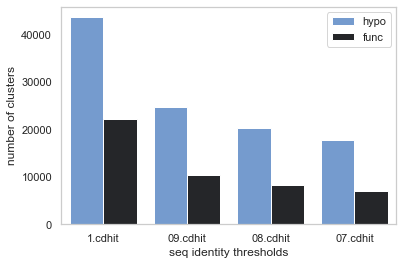

In [211]:
id_groups = get_counts(df_id).rename(columns={"cols": "id"})
hypo_groups = get_counts(df_hypo).rename(columns={"cols": "hypo"})
func_groups = get_counts(df_func).rename(columns={"cols": "func"})
df_plot = pd.concat([hypo_groups, func_groups], axis=0).melt("index", var_name='cols', value_name='vals').dropna()
df_plot
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid': False})
pal = sns.dark_palette("#69d", n_colors=2, reverse=True)
ax = sns.barplot(x='index', y='vals', hue='cols', data=df_plot, palette=pal)
ax.legend().set_title("")
ax.set_xlabel('seq identity thresholds')
ax.set_ylabel('number of clusters')

plot = ax.get_figure()
plot.savefig('/Users/zeyku390/PycharmProjects/H.inflata/plots/figure1b.svg', format="svg")
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)